#  ===== Working with NWB 2.0 format =====
## This notebook is designed to showcase the work flow with NWB 2.0 files related to a typical neuroscience study. The tutorial presents materials accompanying the paper
>Najafi, Farzaneh, Gamaleldin F. Elsayed, Eftychios Pnevmatikakis, John Cunningham, and Anne K. Churchland. "Inhibitory and excitatory populations in parietal cortex are equally selective for decision outcome in both novices and experts." bioRxiv (2018): 354340.
https://www.biorxiv.org/content/early/2018/10/10/354340
#### This study has reported a surprising finding that excitatory and inhibitory neurons are both equally selective in decision making, at both single-cell and population level. Furthermore, they exhibit similar temporal dynamic changes during learning, paralleling behavioral improvments.

## The demonstration includes querying, conditioning and visualization of neuro-data for a single session, as well as for whole study population. To provide use case exampke, several key figures from the paper will be reproduced. 

In [1]:
%matplotlib inline

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pynwb import NWBFile, NWBHDF5IO

## First, we demonstate the working with a single NWB 2.0 file, representing data from a single recording session. We want to obtain the neuronal responses in this session, related to different experimental events, as well as the identified neuron types. 
### The NWB 2.0 files are assumed to be placed in this path:
>../data/NWB 2.0

In [2]:
# Specify data path and filename - here, we just pick one arbitrary example NWB 2.0 file
data_dir = os.path.join('..', 'data', 'NWB 2.0')
fname = 'mouse1_fni16_150817_150817_001_ch2-PnevPanResults-170808-190057.nwb'

In [3]:
# Read NWB 2.0 file
nwb_io = NWBHDF5IO(os.path.join(data_dir, fname), mode = 'r')
nwbfile = nwb_io.read()

## Here, we wish to extract the neuron response time-series
Here, neuron response time-series are stored as trial-segmented, time-locked to several different experimental event (e.g. *start tone*, *stimulus onset*, *choice*, or *reward*).

Thus, these neuron data takes the shape of (ROI count) x (time points) x (trial count), one set of data for each experimental event 
Since these data are trial-based segmented (as opposed to raw), they are stored in NWB 2.0 in a **processing module**, under a **data interface** of type **DfOverF**

In [4]:
# Extract all trial-based ROI time-series
# ROI time-series has the shape of: (ROI count) x (time instances) x (trial count)`
roi_series = nwbfile.modules.get('Trial-based').data_interfaces.get('deconvolved dF-over-F').roi_response_series

The **DfOverF** data interface contains mutliple sets of trial-segmented neuron responses, each stored as a **roi_response_series**. For result figure reproduction purpose, we will extract neuron response time-series time-locked to 4 events: *initial auditory tone onset*, *stimulus onset*, *time of first commit* and *time of second commit*

Each **roi_response_series** contains a field named **rois**, which provides the indices of the ROIs in the **ROI table** specific to this **roi_response_series**

In [5]:
# Display all roi_response_series, named by the event-type that the data are time locked to
for eve in roi_series.keys():
    print(eve)

commitIncorrAl
firstSideTryAl
firstSideTryAl_COM
goToneAl
initToneAl
rewardAl
stimAl_allTrs
stimAl_noEarlyDec
stimOffAl


In [6]:
def get_trialsegmented_roi_timeseries(event_name, pre_stim_dur, post_stim_dur, roi_series):
    event_roi_timeseries = roi_series.get(event_name)
    tvec = event_roi_timeseries.timestamps
    # check if pre/post stim duration is out of bound
    pre_stim_dur = np.maximum(tvec[0], pre_stim_dur)
    post_stim_dur = np.minimum(tvec[-1], post_stim_dur)   
    # extract data
    ix = np.logical_and(tvec >= pre_stim_dur, tvec <= post_stim_dur)
    return np.array(event_roi_timeseries.data)[:, ix, :], np.array(event_roi_timeseries.timestamps)[ix]    

In [7]:
event_roi_timeseries = roi_series.get('firstSideTryAl')
event_roi_timeseries
tvec = event_roi_timeseries.timestamps
print(tvec[0])
print(tvec[-1])

pre_stim_dur = -250
post_stim_dur = 250

pre_stim_dur = np.maximum(tvec[0], pre_stim_dur)
post_stim_dur = np.minimum(tvec[-1], post_stim_dur)   
# extract data
ix = np.logical_and(tvec >= pre_stim_dur, tvec <= post_stim_dur)
print(ix)

-1197.41100324
1197.41100324
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]


Neurons identification is done via a ROI segmentation routine, and the resulted segmentation information is stored under another **processing module** as **ROI-table**. Thus, each neuron (ROI) has a corresponding entry in the **ROI-table** containing ROI-related information such as: good/bad ROI, inhibitory/excitatory ROI, ROI mask, etc.

Here, we wish to extract neurons that are labeled *good* and separate neurons into categories of *excitatory* and *inhibitory*

In [8]:
# Obtain the ROI-table
# here, 'initToneAl' is selected arbitrarily, all of the roi_response_series contain the same ROI-table and good_roi_mask
roi_tcourse = roi_series.get('initToneAl')  
good_roi_mask = roi_tcourse.rois.data  # good_roi_mask here refers a 1D array of ROI indices, indexing into the ROI-table
roi_table = roi_tcourse.rois.table

In [9]:
# Visualizing the ROI-table 
roi_colums = roi_table.colnames
roi_table_df = {}
for c in roi_colums:
    if c == 'image_mask':
        continue
    roi_table_df[c] = roi_table.get(c).data if type(roi_table.get(c).data) is np.ndarray else roi_table.get(c).data.value
roi_table_df = pd.DataFrame(roi_table_df)
roi_table_df

,roi_id,roi_status,neuron_type,fitness,roi2surr_sig,offsets_ch1_pix
0,0,good,excitatory,-inf,0,-1256
1,38,good,excitatory,-inf,0,255
2,39,good,inhibitory,-inf,4,10954
3,41,good,excitatory,-inf,0,90
4,42,good,excitatory,-inf,0,-763
5,43,good,excitatory,-inf,0,656
6,44,good,excitatory,-inf,0,1600
7,45,good,excitatory,-inf,1,1548
8,48,good,excitatory,-inf,0,-314
9,49,good,excitatory,-inf,0,-262


In [10]:
# Obtain inh/exc status of the ROI
neuron_type = roi_table.get('neuron_type').data[good_roi_mask]
# Display neuron_type for ease of visualization
print(neuron_type[1:20])

['excitatory' 'inhibitory' 'excitatory' 'excitatory' 'excitatory'
 'excitatory' 'excitatory' 'excitatory' 'excitatory' 'excitatory'
 'excitatory' 'excitatory' 'excitatory' 'excitatory' 'excitatory'
 'excitatory' 'excitatory' 'unknown' 'excitatory']


## We will now perform minor data conditioning to reproduce Figure 1E 

Again, here we seek to extract trial-segmented ROI data with respect to four events: *initial auditory tone onset*, *stimulus onset*, *time of first commit* and *time of second commit*

We also define the pre-stimulus and post-stimulus amount of time we wish to extract the data from/to

In [11]:
# specify event of interest to extract trial data 
segmentation_settings = [
    {'event':'initToneAl', 'pre': -10000, 'post': 100},
    {'event':'stimAl_noEarlyDec', 'pre': -100, 'post': 10000},
    {'event':'firstSideTryAl', 'pre': -250, 'post': 250},
    {'event':'rewardAl', 'pre': -250, 'post': 10000}]

# extract trial-based data and average over trial
trial_avg_segments = {}
for setting in segmentation_settings:
    # extract segment
    out = get_trialsegmented_roi_timeseries(setting['event'], setting['pre'], setting['post'], roi_series)
    # average
    trial_avg_segments[setting['event']] = (np.nanmean(out[0], axis=2), out[1])

In [12]:
# Function to sort the ROI time-series based on the latency of the peak activity
def roi_sort_by_peak_latency(roi_tcourse):
    sorted_roi_idx = np.argsort(np.argmax(roi_tcourse, axis = 1))
    return roi_tcourse[sorted_roi_idx,:].copy(), sorted_roi_idx

In [13]:
# Sort and concatenate trial-based data time-locked to: start tone, stimulus, 1st commit and 2nd commit

# Concatenate and sort
data_all = np.hstack((value[0] for value in trial_avg_segments.values()))
data_all, sorted_roi_idx = roi_sort_by_peak_latency(data_all)

# Concatenate all timevec(s) and determine the indices of t = 0
tvec_concat = [value[1] for value in trial_avg_segments.values()]
xdim_all = [t.size for t in tvec_concat]
xdim_all.insert(0,0)
zeros_all = [np.where(v == 0)[0][0] for v in tvec_concat]

# Extract inh/exc status
is_inh = np.zeros((data_all.shape[0]))
is_inh[neuron_type[sorted_roi_idx] == 'inhibitory'] = 1

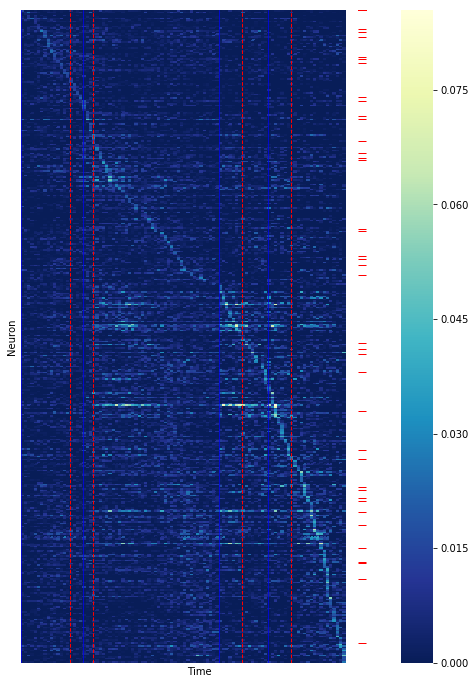

In [14]:
# Raster Plot -  Figure 1E
fig1E = plt.figure(figsize=(8,12))
ax1 = fig1E.add_subplot(111)
ax1.set_facecolor('white')

sns.heatmap(data=data_all, xticklabels=[], yticklabels=[], cmap='YlGnBu_r', axes=ax1, vmin=0)

# add vertical lines
for zidx, z in enumerate(zeros_all):
    ax1.axvline(x=np.cumsum(xdim_all)[zidx], color='b',linestyle='-',linewidth=0.7)
    ax1.axvline(x=z + np.cumsum(xdim_all)[zidx], color='r',linestyle='--',linewidth=1)
    
# add inhibitor marker
ax1.plot(np.ones(is_inh.shape)*(data_all.shape[1]+5), np.arange(is_inh.size)*is_inh, 'r_', markersize=8)

ax1.set_xlim(0, data_all.shape[1]+10)
ax1.set_xlabel('Time')
ax1.set_ylabel('Neuron')
ax1.set_label('Averaged infered spike for all neurons for an example session')

## Similarly, minor data conditioning is required for the reproduction of Figure 1F 

Trial-related information is stored in NWB 2.0 under **trials**. **trials** is a table-like data structure that enforces two required variables as table columns: *start_time* and *stop_time*. User can define any number of additional table columns to store trial-specific information related to their study. 

Here, we have added 10 additional columns: *trial_type*, *trial_pulse_rate*, *trial_response*, *trial_is_good*, *init_tone*, *stim_onset*, *stim_offset*, *go_tone*, *first_commit*, *second_commit*

In [15]:
# Get trial info
trial_set = nwbfile.trials.to_dataframe()
trial_set

,start_time,stop_time,trial_type,trial_pulse_rate,trial_response,trial_is_good,init_tone,stim_onset,stim_offset,go_tone,first_commit,second_commit
id,,,,,,,,,,,,
0,16.345230,8721.846680,Low-rate,7,no trial,False,NaN,NaN,NaN,NaN,NaN,NaN
1,16.348230,3932.205811,High-rate,26,no trial,False,NaN,NaN,NaN,NaN,NaN,NaN
2,16.345230,1213.756226,High-rate,27,no trial,False,NaN,NaN,NaN,NaN,NaN,NaN
3,16.348230,12734.794922,Low-rate,6,no trial,False,NaN,NaN,NaN,NaN,NaN,NaN
4,15.680230,3575.550781,High-rate,26,no trial,False,NaN,NaN,NaN,NaN,NaN,NaN
5,16.345230,12378.804688,High-rate,27,incorrect,True,536.998,988.996,1988.996,1389.326,1792.326,1916.825
6,15.680230,15355.486328,High-rate,27,incorrect,True,1081.829,4012.484,5012.484,4294.148,4768.647,4888.313
7,15.680230,1763.253052,Low-rate,7,no go-tone lick (-1),False,1089.496,1146.996,1310.495,NaN,NaN,NaN
8,16.179230,4546.923340,Low-rate,6,correct,True,1504.660,2329.157,3329.157,2464.657,2933.488,3058.654


For the reproduction of Figure 1F, we wish to extract neuronal responses of *excitatory* and *inhibitory* neurons, separated by *trial type* category of either *High Rate* or *Low Rate*, and constrained by the condition that the mouse's response for this trial is correct

In [16]:
trial_is_good = trial_set.trial_is_good
trial_response_type = trial_set.trial_response
trial_type = trial_set.trial_type

In [17]:
# make trial-mask for correct high-rate (ipsilateral-lick) and low-rate (contralateral-lick) trial
correct_high_rate_trial = np.logical_and(trial_response_type == 'correct', trial_type == 'High-rate').values
correct_low_rate_trial = np.logical_and(trial_response_type == 'correct', trial_type == 'Low-rate').values

In [18]:
# make mask of inhibitory and excitatory neuron
is_inh = (neuron_type == 'inhibitory')
is_exc = (neuron_type == 'excitatory')

In [19]:
# specify event of interest to extract trial data 
segmentation_settings = [
    {'event':'initToneAl', 'pre': -10000, 'post': 100},
    {'event':'stimAl_noEarlyDec', 'pre': -100, 'post': 10000},
    {'event':'firstSideTryAl', 'pre': -250, 'post': 250},
    {'event':'rewardAl', 'pre': -250, 'post': 10000}]

trial_avg_segments = {}
for setting in segmentation_settings:
    # extract segment
    out = get_trialsegmented_roi_timeseries(setting['event'], setting['pre'], setting['post'], roi_series)
    # mask by high/low rate trial and inh/exc neuron type
    exc_correct_hr = out[0][:, :, correct_high_rate_trial][is_exc, :, :]
    inh_correct_hr = out[0][:, :, correct_high_rate_trial][is_inh, :, :]
    exc_correct_lr = out[0][:, :, correct_low_rate_trial][is_exc, :, :]
    inh_correct_lr = out[0][:, :, correct_low_rate_trial][is_inh, :, :]
    # take average across trials
    trial_avg_segments[setting['event']] = {'exc_correct_hr': np.nanmean(exc_correct_hr, axis=2),
                                            'inh_correct_hr': np.nanmean(inh_correct_hr, axis=2),
                                            'exc_correct_lr': np.nanmean(exc_correct_lr, axis=2),
                                            'inh_correct_lr': np.nanmean(inh_correct_lr, axis=2),
                                            'timestamps': out[1]}

In [20]:
# plot a single subplot of Figure 1F
def plot_sub_fig1F(exc_ax, inh_ax, trial_avg_segments, exc_idx, inh_idx):    
  
    # make a nan-padding between each dataset 
    pad_size = 3
    nan_padding = np.full(pad_size, np.nan)
    
    # Concatenate and add nan padding in between    
    r = {k: np.hstack(np.hstack((v[k][idx,:], nan_padding)) for v in trial_avg_segments.values()) 
                       for k, idx in (('exc_correct_hr', exc_idx),
                                      ('inh_correct_hr', inh_idx),
                                      ('exc_correct_lr', exc_idx),
                                      ('inh_correct_lr', inh_idx))}    
    tvec = np.hstack(np.hstack((v['timestamps'], nan_padding)) for v in trial_avg_segments.values())      
    
    # determine the indices of t = 0
    t_zeros = np.where(tvec == 0)[0]

    for ax, roi_key in ((exc_ax, ('exc_correct_lr', 'exc_correct_hr')),  (inh_ax, ('inh_correct_lr', 'inh_correct_hr'))):
            ax.plot(r[roi_key[0]], 'k', alpha=0.6) 
            ax.plot(r[roi_key[1]], 'g', alpha=0.8)   
            # add vertical lines
            for t in t_zeros:
                ax.axvline(x=t, color='k', linestyle='--', linewidth=0.7)
                ax.set_facecolor('w')
                ax.set_xticklabels([])
                ax.set_title(roi_key[0].split('_')[0])

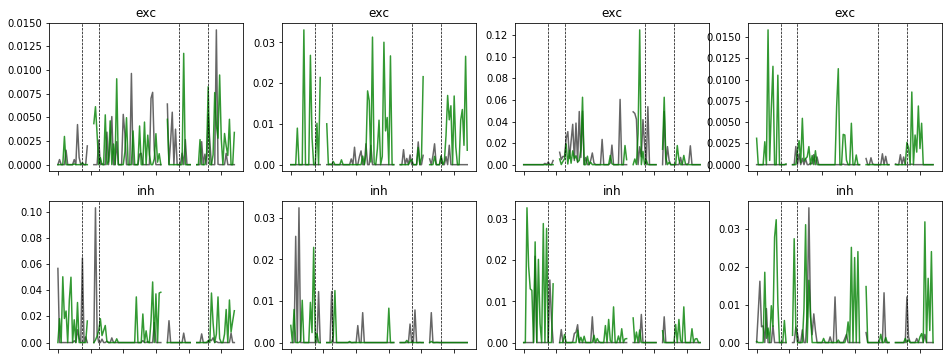

In [21]:
# Plot figure 1F
fig1F, axes = plt.subplots(2, 4, figsize=(16,6))
for a, e, i in zip(axes.T, [5, 11, 22, 25], [5, 6, 7, 22]):
    plot_sub_fig1F(a[0], a[1], trial_avg_segments, e, i)

In [22]:
nwb_io.close()

## Reproducion of Figure 1H 

From all session, obtain neuron inferred spike activity (average of 3-frames before choice) for inhibitory and excitatory neurons.

Since each NWB 2.0 represent data from a single recording session, we will iterate through all session and extract the mean spiking response in ~100 ms prior to the time of *first commit* (*choice*-event) for all *inhibitory* and *excitatory* neurons 

In [23]:
def extract_all_roi_timeseries():
    choice_event_key = 'firstSideTryAl'
    pre_dur = -97
    post_dur = 0
    
    for f in os.listdir(data_dir):
        # Read NWB 2.0 file
        nwb_io = NWBHDF5IO(os.path.join(data_dir, f), mode = 'r')
        nwbfile = nwb_io.read()

        roi_series = nwbfile.modules.get('Trial-based').data_interfaces.get('deconvolved dF-over-F').roi_response_series

        # Obtain inh/exc status of the ROI
        roi_tcourse = roi_series.get(choice_event_key)
        good_roi_mask = roi_tcourse.rois.data
        roi_table = roi_tcourse.rois.table
        neuron_type = roi_table.get('neuron_type').data[good_roi_mask]
        
        # get trial status
        tr_set = nwbfile.trials.to_dataframe()
        tr_filters = (tr_set.trial_is_good == True).values

        roi_ts, _ = get_trialsegmented_roi_timeseries(choice_event_key, pre_dur, post_dur, roi_series)
        nwb_io.close()

        # average over timepoints
        yield {'inh_rois': np.mean(roi_ts[neuron_type == 'inhibitory', :, :][:, :, tr_filters], axis=1),
               'exc_rois': np.mean(roi_ts[neuron_type == 'excitatory', :, :][:, :, tr_filters], axis=1),
               'inh_count': roi_ts[neuron_type == 'inhibitory', :, :].shape[0],
               'exc_count': roi_ts[neuron_type == 'excitatory', :, :].shape[0]}    

In [24]:
avg_inh_rois, avg_exc_rois, inh_counts, exc_counts = zip(*((r['inh_rois'], 
                                                            r['exc_rois'],
                                                            r['inh_count'],
                                                            r['exc_count']) 
                                                           for r in extract_all_roi_timeseries()))

In [25]:
# average over trial
trial_avg_exc_rois = np.hstack(np.nanmean(r, axis=1) for r in avg_exc_rois)
trial_avg_inh_rois = np.hstack(np.nanmean(r, axis=1) for r in avg_inh_rois)

Excitatory neurons: 44546 - Inhibitory neurons: 5530


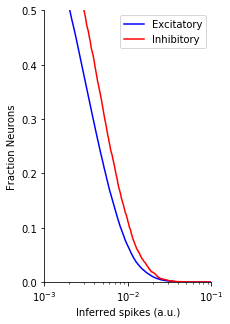

In [26]:
# process and plot Figure 1H
spike_val_vec = np.logspace(-3, 0, 1000)
exc_roi_frac = np.sum(trial_avg_exc_rois[:, None] > spike_val_vec, axis=0) / len(trial_avg_exc_rois)
inh_roi_frac = np.sum(trial_avg_inh_rois[:, None] > spike_val_vec, axis=0) / len(trial_avg_inh_rois)

print(f'Excitatory neurons: {sum(exc_counts)} - Inhibitory neurons: {sum(inh_counts)}')
fig1H, ax = plt.subplots(1, 1, figsize=(3, 5))
ax.semilogx(spike_val_vec, exc_roi_frac, 'b', label='Excitatory')
ax.semilogx(spike_val_vec, inh_roi_frac, 'r', label='Inhibitory')
ax.legend()
ax.set_ylabel('Fraction Neurons')
ax.set_xlabel('Inferred spikes (a.u.)')
ax.set_xlim(1e-3, 1e-1)
ax.set_ylim(0, 0.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [27]:
# exc and inh roi count for each session
df = pd.DataFrame([(f for f in os.listdir(data_dir)), exc_counts, inh_counts]).T
df.columns = ['session', 'exc_count', 'inh_count']
print(f'Average ROI count across sessions - Exc: {df.exc_count.mean()} - Inh: {df.inh_count.mean()}')
df

Average ROI count across sessions - Exc: 329.97037037037035 - Inh: 40.96296296296296


,session,exc_count,inh_count
0,mouse1_fni16_150817_150817_001_ch2-PnevPanResu...,280,38
1,mouse1_fni16_150818_150818_001_ch2-PnevPanResu...,264,42
2,mouse1_fni16_150819_150819_001_ch2-PnevPanResu...,305,39
3,mouse1_fni16_150820_150820_001_ch2-PnevPanResu...,341,49
4,mouse1_fni16_150821_150821_001-002_ch2-PnevPan...,342,48
5,mouse1_fni16_150825_150825_001-002-003_ch2-Pne...,363,51
6,mouse1_fni16_150826_150826_001_ch2-PnevPanResu...,284,44
7,mouse1_fni16_150827_150827_001_ch2-PnevPanResu...,340,46
8,mouse1_fni16_150828_150828_001-002_ch2-PnevPan...,333,50
9,mouse1_fni16_150831_150831_001-002_ch2-PnevPan...,385,48
